# Processing Mirage22 Data
The data has been converted from the provided JSON to a csv with the headers
`five-tuple,timestamp,iat,packet_size`

1. Seperate the IP flows
2. Use inter-arrival time to verify data integrity

In [13]:
pcap_df = pd.read_csv(r"data\discord_data\70.csv")

### Seperating IP Flows

In [12]:
def seperate_flows(pcap_df):
    return dict(tuple(df.groupby('five-tuple')))

### Verify Data Integrity

In [48]:
flows = seperate_flows(pcap_df)
print("total flows: ", len(flows))
flow_stats = []
for flow_key in flows.keys():
    flow = flows[flow_key]
    length = flow.shape[0]
    start = flow.timestamp.min()
    end = flow.timestamp.max()
    total_time = end - start
    iat_sum = flow['iat'].sum()
    md_pkt_sz = flow['packet_size'].median()
    flow_stats.append([flow_key, length, start, end, total_time, iat_sum, md_pkt_sz])

flow_stats_df = pd.DataFrame(flow_stats, columns=['five-tuple', 'size', 'start', 'end', 'total_time', 'iat_sum', 'md_pkt_sz'])

total flows:  45


In [49]:
flow_stats_df

,five-tuple,size,start,end,total_time,iat_sum,md_pkt_sz
0,"192.168.20.104,32864,213.163.94.112,50004,17",51153,1.636715e+09,1.636715e+09,120.100023,120.100023,1179.0
1,"192.168.20.104,35704,162.159.130.234,443,6",54,1.636714e+09,1.636714e+09,10.829455,10.829455,65.0
2,"192.168.20.104,35715,162.159.130.234,443,6",158,1.636714e+09,1.636715e+09,931.261785,931.261785,65.0
3,"192.168.20.104,37661,213.163.94.112,50004,17",30287,1.636714e+09,1.636714e+09,60.126262,60.126262,1192.0
4,"192.168.20.104,38006,213.163.94.112,50004,17",25081,1.636715e+09,1.636715e+09,60.080159,60.080159,1192.0
5,"192.168.20.104,39395,213.163.94.112,50004,17",57613,1.636715e+09,1.636715e+09,120.093567,120.093567,1198.0
6,"192.168.20.104,41719,162.159.128.232,443,6",27,1.636714e+09,1.636715e+09,300.654138,300.654138,40.0
7,"192.168.20.104,41864,213.163.94.112,50004,17",27906,1.636715e+09,1.636715e+09,60.114605,60.114605,1197.0
8,"192.168.20.104,42250,213.163.94.112,50004,17",28780,1.636715e+09,1.636715e+09,60.088308,60.088308,1209.0
9,"192.168.20.104,46846,162.159.128.235,443,6",1260,1.636714e+09,1.636715e+09,920.248021,920.248021,91.0


### CDF of IAT and Packet Size

In [50]:
test_flow = flows['192.168.20.104,32864,213.163.94.112,50004,17']

In [73]:
outlier_cap = test_flow['iat'].quantile(.99)
filtered_iat = test_flow[test_flow['iat'] < outlier_cap]['iat']

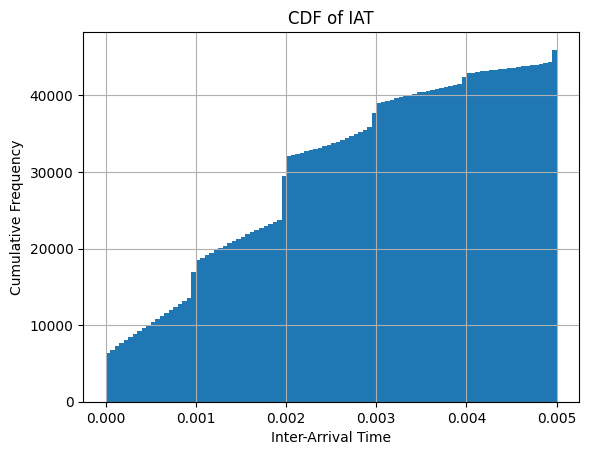

In [76]:
filtered_iat.hist(bins=100,  cumulative=1)
plt.title('CDF of IAT')
plt.xlabel('Inter-Arrival Time')
plt.ylabel('Cumulative Frequency')
plt.show()

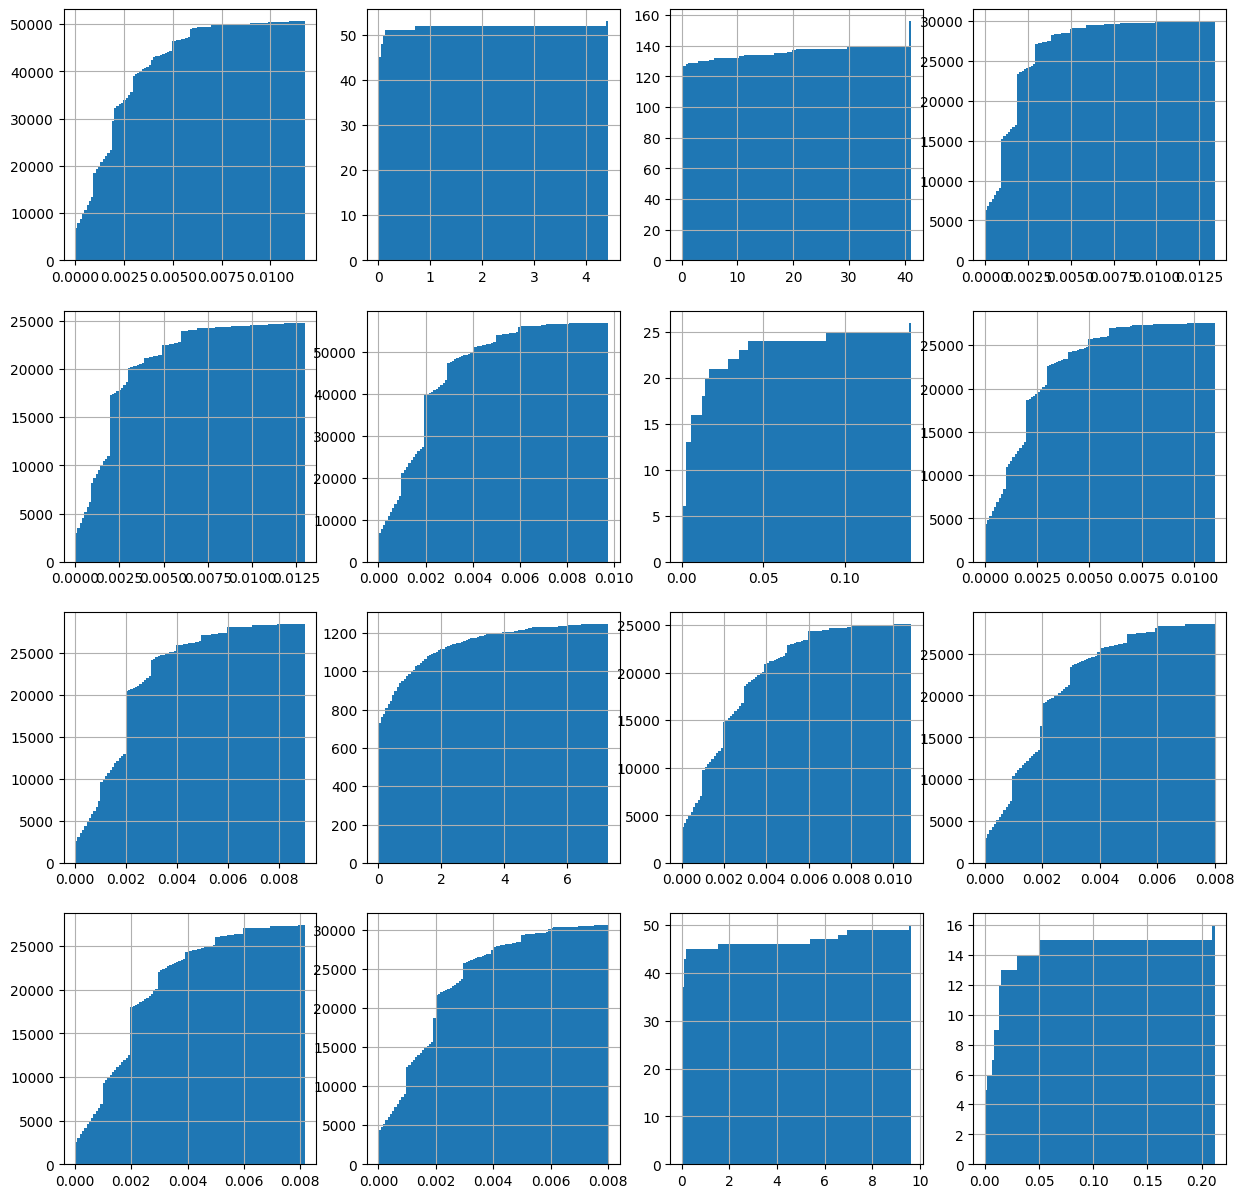

In [83]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
for i,flow_key in enumerate(list(flows.keys())[:16]):
    test_flow = flows[flow_key]
    outlier_cap = test_flow['iat'].quantile(.99)
    filtered_iat = test_flow[test_flow['iat'] < outlier_cap]['iat']
    row, col = divmod(i, 4)  # Calculate the row and column index
    filtered_iat.hist(bins=100,  cumulative=1, ax=axs[row, col])

### Converting flow to FlowPic variant

In [84]:
def create_flowpic(flow_df):

    # Filter out packets with size greater than 1500
    flow_df = flow_df[flow_df['packet_size'] <= 1500]

    # Normalize time of arrival values
    flow_df['normalized_timestamp'] = flow_df['timestamp'] - flow_df['timestamp'].min()
    # flow_df = flow_df[(flow_df['normalized_timestamp'] < 500) & (flow_df['normalized_timestamp'] > 15)]
    
    # Normalize time of arrival values to be between 0 and 1500
    max_time = 1500
    flow_df['normalized_timestamp'] = (flow_df['normalized_timestamp'] / flow_df['normalized_timestamp'].max()) * max_time

    plt.figure()
    plt.scatter(flow_df['normalized_timestamp'], flow_df['packet_size'], marker=',', c='k', s=5)

    # Plot the FlowPic
    # plt.imshow(histogram.T, origin='lower', extent=[0, max_time, 1, 1500], aspect='auto', cmap='viridis')
    plt.xlabel('Normalized Time of Arrival')
    plt.ylabel('Packet Size')
    plt.title('FlowPic')
    plt.set_cmap('binary')
    # plt.axes().set_aspect('equal')
    plt.show()

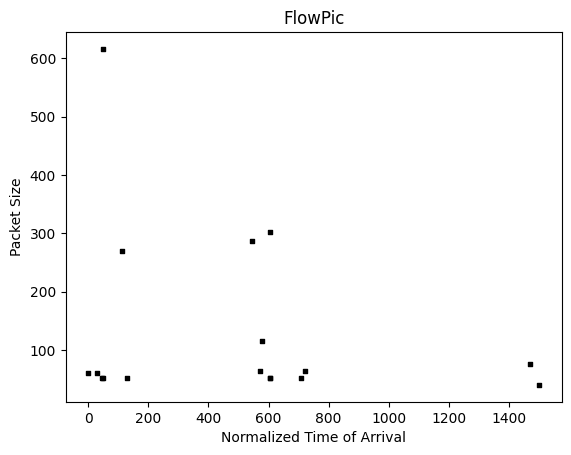

In [87]:
create_flowpic(test_flow)

,five-tuple,timestamp,iat,packet_size
292347,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.000000,102
292348,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.037768,102
292349,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.014230,1231
292350,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.005004,1231
292351,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.003999,76
...,...,...,...,...
343495,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.005998,1087
343496,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.000011,1222
343497,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.005983,1222
343498,"192.168.20.104,32864,213.163.94.112,50004,17",1.636715e+09,0.004997,1223
